In [1]:
# 1. Instalación de dependencias
%pip install tensorflow fiftyone

  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached cffi-1.17.1-cp313-cp313-win_amd64.whl.metadata (1.6 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
  Using cached wsproto-1.2.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-win_amd64.whl.metadata (4.1 kB)
  

In [1]:
import fiftyone.zoo as foz

# Descargamos subconjunto pequeño de Open Images
dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    label_types=["detections"],
    classes=["Person", "Chair", "Cup", "Book", "Car", "Cat"],
    max_samples=200
)
print("Samples:", len(dataset))


Ignoring invalid classes ['Cup']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`
 100% |███████████████████| 200/200 [8.5s elapsed, 0s remaining, 42.8 files/s]      
Dataset info written to 'C:\Users\Personal\fiftyone\open-images-v6\info.json'
Loading 'open-images-v6' split 'validation'
Ignoring invalid classes ['Cup']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`
 100% |█████████████████| 200/200 [2.7s elapsed, 0s remaining, 73.9 samples/s]      
Dataset 'open-images-v6-validation-200' created
Samples: 200


In [2]:
import numpy as np
import tensorflow as tf
import cv2

IMG_SIZE = 128  # reducimos tamaño por simplicidad
CLASSES = ["Person", "Chair", "Cup", "Book", "Car", "Cat"]
class_to_idx = {c: i for i, c in enumerate(CLASSES)}

images, labels, bboxes = [], [], []

for sample in dataset:
    img = cv2.imread(sample.filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0

    for det in sample.ground_truth.detections:
      if det.label in class_to_idx:
        ymin, xmin, ymax, xmax = det.bounding_box
        labels.append(class_to_idx[det.label])
        bboxes.append([ymin, xmin, ymax, xmax])
        images.append(img)

images = np.array(images)
labels = np.array(labels)
bboxes = np.array(bboxes)

print("Dataset shape:", images.shape, labels.shape, bboxes.shape)

Dataset shape: (476, 128, 128, 3) (476,) (476, 4)


In [3]:
from tensorflow.keras import layers, models, Input

def build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(CLASSES)):
    inputs = Input(shape=input_shape)

    # Backbone CNN
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)

    # Cabeza de clasificación
    class_out = layers.Dense(num_classes, activation="softmax", name="class_output")(x)

    # Cabeza de regresión (bounding boxes)
    bbox_out = layers.Dense(4, activation="sigmoid", name="bbox_output")(x)

    model = models.Model(inputs, [class_out, bbox_out])
    return model

model = build_cnn()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  8,388,864 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 6)         │      1,542 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      1,028 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,484,682 (32.37 MB)

 Trainable params: 8,484,682 (32.37 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model.compile(
    optimizer="adam",
    loss={
        "class_output": "sparse_categorical_crossentropy",
        "bbox_output": "mse"
    },
    loss_weights={
        "class_output": 1.0,
        "bbox_output": 2.0  # damos más importancia a precisión de boxes
    },
    metrics={"class_output": "accuracy"}
)

history = model.fit(
    images, {"class_output": labels, "bbox_output": bboxes},
    epochs=10,
    batch_size=16,
    validation_split=0.2
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - bbox_output_loss: 0.0900 - class_output_accuracy: 0.5868 - class_output_loss: 1.0442 - loss: 1.2252 - val_bbox_output_loss: 0.0926 - val_class_output_accuracy: 0.5625 - val_class_output_loss: 0.9155 - val_loss: 1.1007
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - bbox_output_loss: 0.0842 - class_output_accuracy: 0.6947 - class_output_loss: 0.6434 - loss: 0.8117 - val_bbox_output_loss: 0.0911 - val_class_output_accuracy: 0.6354 - val_class_output_loss: 0.7996 - val_loss: 0.9818
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - bbox_output_loss: 0.0758 - class_output_accuracy: 0.8263 - class_output_loss: 0.4567 - loss: 0.6103 - val_bbox_output_loss: 0.0893 - val_class_output_accuracy: 0.5729 - val_class_output_loss: 0.8608 - val_loss: 1.0394
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - bbox_output_loss: 0.0708 - class_output_accuracy: 0.8974 - class_output_loss: 0.3137 - loss: 0.4569 - val_bbox_output_loss: 0.0985

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


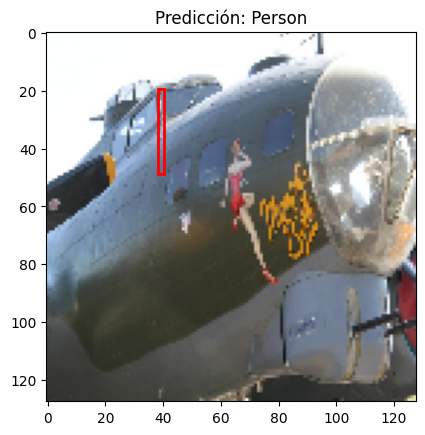

In [6]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(images))
img = np.expand_dims(images[idx], axis=0)

pred_class, pred_bbox = model.predict(img)
pred_class = np.argmax(pred_class[0])
pred_bbox = pred_bbox[0]

plt.imshow(images[idx])
plt.title(f"Predicción: {CLASSES[pred_class]}")
h, w, _ = images[idx].shape
ymin, xmin, ymax, xmax = pred_bbox
plt.gca().add_patch(plt.Rectangle(
    (xmin*w, ymin*h), (xmax-xmin)*w, (ymax-ymin)*h,
    fill=False, color="red", linewidth=2
))
plt.show()